<a href="https://colab.research.google.com/github/Itaigiliutin/Hishuvit3/blob/main/part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning with PyTorch and Scikit-Learn  
# -- Code Examples

## Package version checks

In [ ]:
import sys
sys.path.insert(0, '..')

In [ ]:
from IPython.display import Image
%matplotlib inline

# Classifying handwritten digits

## Obtaining and preparing the MNIST dataset

The MNIST dataset is publicly available at http://yann.lecun.com/exdb/mnist/ and consists of the following four parts:

- Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 examples)
- Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
- Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 examples)
- Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)



In [1]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Normalize to [-1, 1] range:

In [2]:
X = ((X / 255.) - .5) * 2

Visualize the first digit of each class:

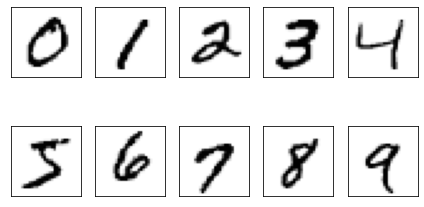

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

Visualize 25 different versions of "7":

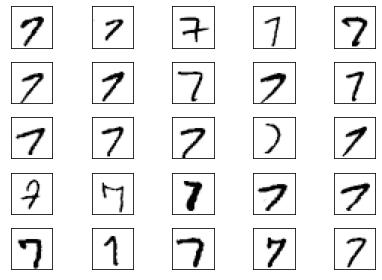

In [4]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

Split into training, validation, and test set:

In [5]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp, X, y

<br>
<br>

## Implementing a multi-layer perceptron

In [6]:
import numpy as np

In [7]:
##########################
### MODEL
##########################

def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h, d_loss__d_b_h)

In [8]:
##########################
### OUR MODEL
##########################

def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class OurNeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden 1 and 2
        rng = np.random.RandomState(random_seed)
        
        self.weight_h_1 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h_1 = np.zeros(num_hidden)

        self.weight_h_2 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_hidden))
        self.bias_h_2 = np.zeros(num_hidden)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer 1
        # input dim: [n_examples, n_features] dot [n_features ,n_hidden]
        # output dim: [n_examples, n_hidden]
        z_h_1 = np.dot(x, self.weight_h_1.T) + self.bias_h_1
        a_h_1 = sigmoid(z_h_1)

         # Hidden layer 2
        # input dim: [n_examples, n_hidden] dot [n_features, n_hidden]
        # output dim: [n_examples, n_hidden]
        z_h_2 = np.dot(a_h_1, self.weight_h_2.T) + self.bias_h_2
        a_h_2 = sigmoid(z_h_2)


        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_hidden, n_hidden]
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h_2, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h_1, a_h_2, a_out

    def backward(self, x, a_h_1,a_h_2, a_out, y):  

        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]
        d_a_out__d_z_out = a_out * (1. - a_out) 
        delta_out = d_loss__d_a_out * d_a_out__d_z_out 
        d_z_out__dw_out = a_h_2
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)       
        
        d_z_out__a_h_2 = self.weight_out
        d_loss__a_h_2 = np.dot(delta_out, d_z_out__a_h_2)
        d_a_h__d_z_h_2 = a_h_2 * (1. - a_h_2) 
        d_z_h__d_w_h_1 = a_h_1
        delta_2 = d_loss__a_h_2 * d_a_h__d_z_h_2
        d_loss__d_w_h_2 = np.dot(delta_2.T, d_z_h__d_w_h_1)
        d_loss__d_b_h_2 = np.sum(delta_2, axis=0)

        d_z_out__a_h_1 = self.weight_h_2
        d_loss__a_h_1 = np.dot(delta_2, d_z_out__a_h_1)
        d_a_h__d_z_h_1 = a_h_1 * (1. - a_h_1) 
        d_loss__d_w_h_1 = np.dot((d_loss__a_h_1 * d_a_h__d_z_h_1).T, x)
        d_loss__d_b_h_1 = np.sum((d_loss__a_h_1 * d_a_h__d_z_h_1), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h_2, d_loss__d_b_h_2,
                d_loss__d_w_h_1, d_loss__d_b_h_1)

In [9]:
model = OurNeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

## Coding the neural network training loop

Defining data loaders:

In [ ]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

        
# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)
    
    for X_train_mini, y_train_mini in minibatch_gen:

        break
        
    break
    
print(X_train_mini.shape)
print(y_train_mini.shape)

Defining a function to compute the loss and accuracy

In [ ]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 


_,_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

In [26]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def macroAuc(probas, target, num_labels):
  auc = []
  for idx in range(num_labels):
    probas_class = [x[idx] for x in probas]
    fpr, tpr, thresholds = metrics.roc_curve(target, probas_class, pos_label = 1)
    auc.append(metrics.auc(fpr, tpr))
  return sum(auc) / len(auc)
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
    probab = []
    target = []
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _,_, probas = nnet.forward(features)
        probab = [*probab, *[softmax(prob) for prob in probas]]
        target = [*target,*targets]
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    #auc = macroAuc(np.array(probab),y,num_labels)
    auc = roc_auc_score(target, probab, multi_class='ovo')
    return mse, acc, auc

In [ ]:
mse, acc, auc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')
print(auc)

In [28]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    epoch_train_auc = []
    epoch_valid_auc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h_1, a_h_2, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h_2, d_loss__d_b_h_2, d_loss__d_w_h_1, d_loss__d_b_h_1 = \
                model.backward(X_train_mini, a_h_1,a_h_2, a_out, y_train_mini)

            #### Update weights ####
            #hidden layer 1
            model.weight_h_1 -= learning_rate * d_loss__d_w_h_1
            model.bias_h_1 -= learning_rate * d_loss__d_b_h_1

            #hidden layer 2
            model.weight_h_2 -= learning_rate * d_loss__d_w_h_2
            model.bias_h_2 -= learning_rate * d_loss__d_b_h_2

            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc, train_auc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc , valid_auc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_train_auc.append(train_auc)
        epoch_valid_auc.append(valid_auc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%'
              f'| Train Auc: {train_auc:.2f}%'
              f'| Valid Auc: {valid_auc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc, epoch_train_auc,epoch_valid_auc

In [ ]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc, epoch_train_auc, epoch_valid_auc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)

## Evaluating the neural network performance

In [ ]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

In [ ]:
plt.plot(range(len(epoch_loss)), epoch_valid_auc)
plt.title('MACRO AUC for validation')
plt.ylabel('Macro Auc')
plt.xlabel('Epoch')
plt.show()

In [ ]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [ ]:
test_mse, test_acc, test_auc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_auc*100:.2f}%')

Plot failure cases:

In [ ]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_,_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, 
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()

<br>
<br>

# FC

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
import torchvision

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/content/results/model.pth')
      torch.save(optimizer.state_dict(), '/content/results/optimizer.pth')

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3283, Accuracy: 1138/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.339568
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.295768
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.301867
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.272979
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.261569
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.198385
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.245474
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.115467
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.067695
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.070719
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.150651
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.869140
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.772831
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.752070
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.892707
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.468350
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.323380
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.243007
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.299373
Train Epoch: 1 [12160

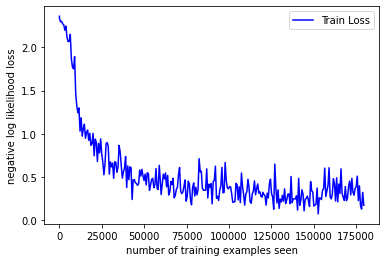

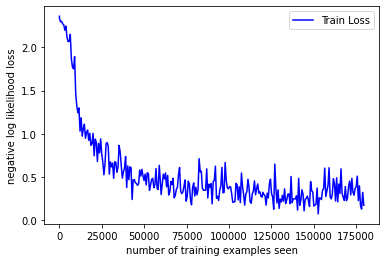

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig